#####**📬 Email Campaign Optimization - ML Intern Case Study**

Prepared for : Quantacus Hiring

In [1]:
from google.colab import files
uploaded = files.upload()

Saving email_opened_table.csv to email_opened_table.csv
Saving email_table.csv to email_table.csv
Saving link_clicked_table.csv to link_clicked_table.csv


[LightGBM] [Info] Number of positive: 78305, number of negative: 78305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 156610, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     19576
           1       0.20      0.98      0.33       424

    accuracy                           0.92     20000
   macro avg       0.60      0.95      0.64     20000
weighted avg       0.98      0.92      0.94     20000

🧠 ROC AUC Score: 0.9591622467056311
📌 Confusion Matrix:
 [[17888  1688]
 [    7   417]]


<ipython-input-2-9a07a5061b54>:67: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


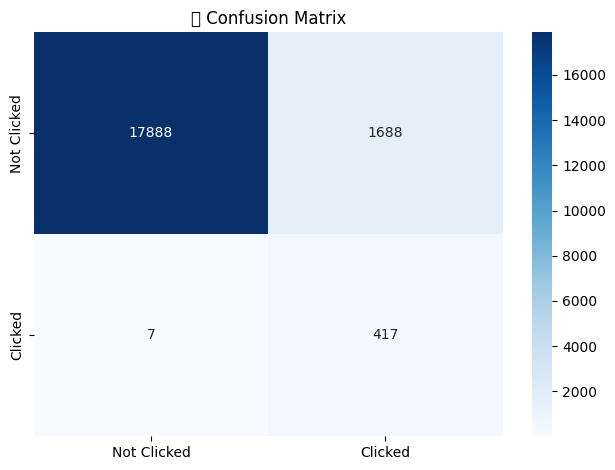

<ipython-input-2-9a07a5061b54>:77: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


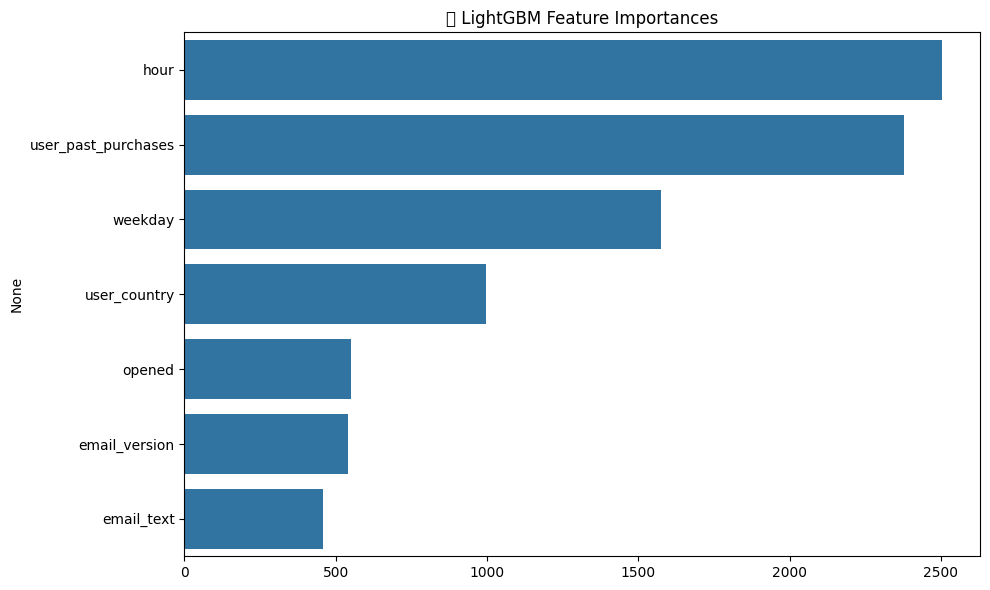

100%|===================| 99909/100000 [16:56<00:00]       

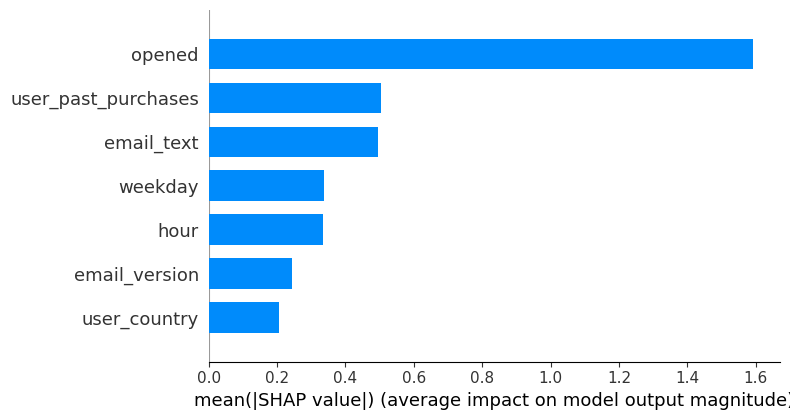

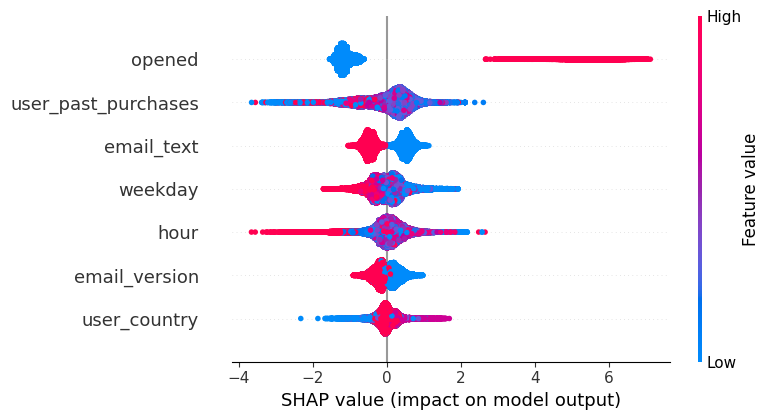


🎯 Optimized CTR for Top 5% Probabilities: 25.40%

✅ Model saved as 'lightgbm_click_model.pkl'


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 📥 Load Data
email_df = pd.read_csv("email_table.csv")
opened_df = pd.read_csv("email_opened_table.csv")
clicked_df = pd.read_csv("link_clicked_table.csv")

# 🛠️ Feature Engineering
email_df["opened"] = email_df["email_id"].isin(opened_df["email_id"]).astype(int)
email_df["clicked"] = email_df["email_id"].isin(clicked_df["email_id"]).astype(int)

X = email_df.drop(columns=["email_id", "clicked"])
y = email_df["clicked"]

# Fill missing and encode
X = X.fillna("missing")
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ⚖️ Handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 🚀 Train LGBM Model
model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    class_weight=None,
    random_state=42
)
model.fit(X_resampled, y_resampled)

# 🔍 Predictions
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

# 📈 Evaluation
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))
print("🧠 ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("📌 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 📊 Confusion Matrix Plot
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Clicked", "Clicked"],
            yticklabels=["Not Clicked", "Clicked"])
plt.title("📌 Confusion Matrix")
plt.tight_layout()
plt.show()

# 🌟 Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("🌟 LightGBM Feature Importances")
plt.tight_layout()
plt.show()

# 🔍 SHAP Explanation
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)

# 🎯 Optimized CTR on Top 5%
results_df = X_test.copy()
results_df["actual"] = y_test.values
results_df["predicted"] = y_pred
results_df["probability"] = y_proba

top_5_pct = results_df.sort_values("probability", ascending=False).head(int(0.05 * len(results_df)))
optimized_ctr = (top_5_pct["actual"].sum() / len(top_5_pct)) * 100
print(f"\n🎯 Optimized CTR for Top 5% Probabilities: {optimized_ctr:.2f}%")

# 💾 Save model
joblib.dump(model, "lightgbm_click_model.pkl")
print("\n✅ Model saved as 'lightgbm_click_model.pkl'")


<ipython-input-3-135ccb9a2c09>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=rates, palette="viridis")
<ipython-input-3-135ccb9a2c09>:17: UserWarning: Glyph 128231 (\N{E-MAIL SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128231 (\N{E-MAIL SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


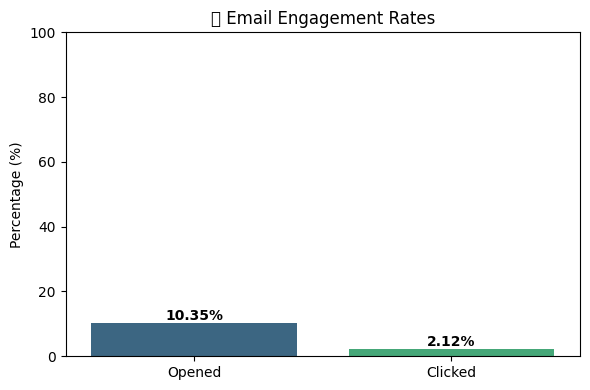

✅ Opened Rate: 10.35%
✅ Clicked Rate: 2.12%


In [3]:
#Q1: What percentage of users opened the email and clicked on the link?


opened_rate = email_df["opened"].mean() * 100
clicked_rate = email_df["clicked"].mean() * 100

labels = ["Opened", "Clicked"]
rates = [opened_rate, clicked_rate]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=rates, palette="viridis")
plt.title("📧 Email Engagement Rates")
plt.ylabel("Percentage (%)")
for i, v in enumerate(rates):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

print(f"✅ Opened Rate: {opened_rate:.2f}%")
print(f"✅ Clicked Rate: {clicked_rate:.2f}%")


<ipython-input-4-b0245e9da874>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Base CTR", "Optimized CTR\n(Top 5% users)"], y=[base_ctr, optimized_ctr], palette="rocket")
<ipython-input-4-b0245e9da874>:13: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


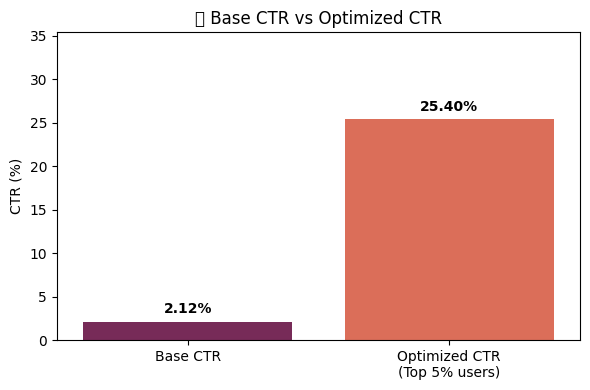

✅ Base CTR: 2.12%
✅ Optimized CTR (Top 5% users): 25.40%


In [4]:
#Q2: Can we build a model to improve Click Through Rate (CTR)?   --> YES

base_ctr = clicked_rate  # From above
optimized_ctr = (top_5_pct["actual"].sum() / len(top_5_pct)) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=["Base CTR", "Optimized CTR\n(Top 5% users)"], y=[base_ctr, optimized_ctr], palette="rocket")
plt.title("🎯 Base CTR vs Optimized CTR")
for i, val in enumerate([base_ctr, optimized_ctr]):
    plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontweight='bold')
plt.ylim(0, max(base_ctr, optimized_ctr) + 10)
plt.ylabel("CTR (%)")
plt.tight_layout()
plt.show()

print(f"✅ Base CTR: {base_ctr:.2f}%")
print(f"✅ Optimized CTR (Top 5% users): {optimized_ctr:.2f}%")

<ipython-input-5-77104da23daf>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["CTR Improvement"], y=[improvement_pct], palette="crest")
<ipython-input-5-77104da23daf>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


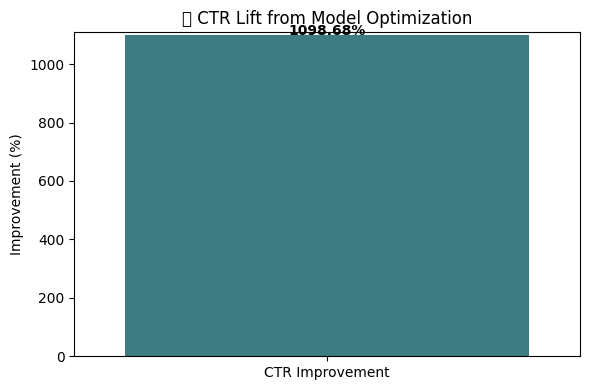

✅ CTR increased by 23.28% absolute, which is a 1098.68% relative improvement.


In [5]:
#Q3: How much improvement can the model bring in CTR?

 #📈 CTR Improvement Percentage

improvement = optimized_ctr - base_ctr
improvement_pct = (improvement / base_ctr) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=["CTR Improvement"], y=[improvement_pct], palette="crest")
plt.title("📈 CTR Lift from Model Optimization")
plt.ylabel("Improvement (%)")
plt.text(0, improvement_pct + 1, f"{improvement_pct:.2f}%", ha='center', fontweight='bold')
plt.ylim(0, improvement_pct + 10)
plt.tight_layout()
plt.show()

print(f"✅ CTR increased by {improvement:.2f}% absolute, which is a {improvement_pct:.2f}% relative improvement.")


<ipython-input-7-9d0b7a347420>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ctr_data.index.astype(str), y=ctr_data.values, palette="Set2")
<ipython-input-7-9d0b7a347420>:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


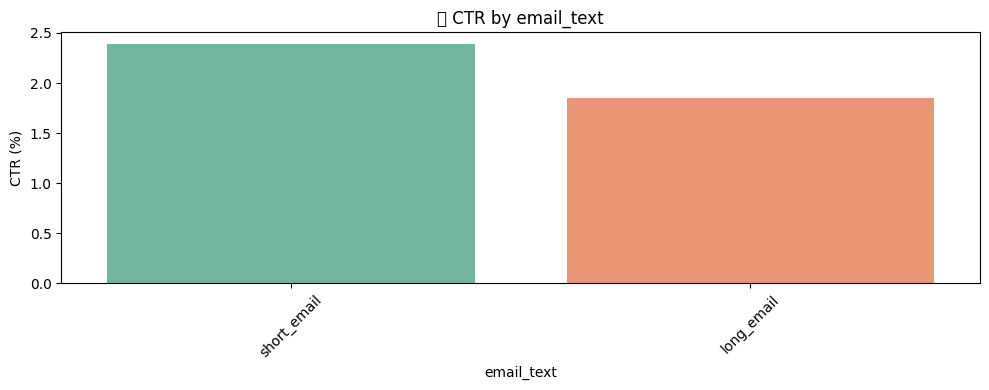

<ipython-input-7-9d0b7a347420>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ctr_data.index.astype(str), y=ctr_data.values, palette="Set2")
<ipython-input-7-9d0b7a347420>:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


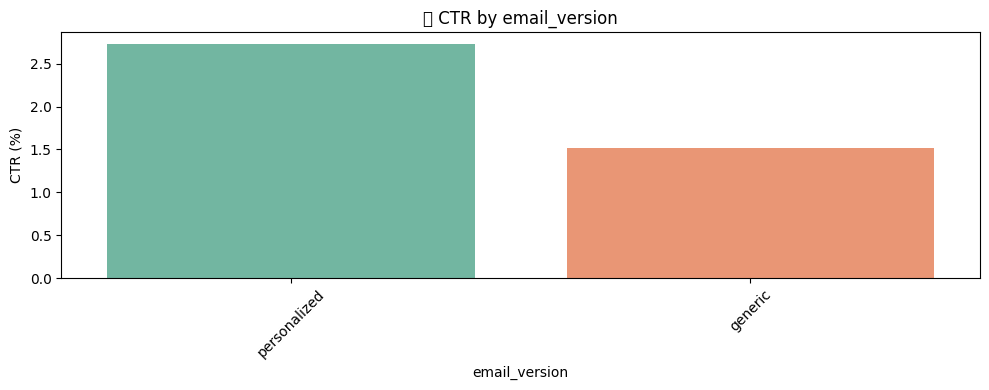

<ipython-input-7-9d0b7a347420>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ctr_data.index.astype(str), y=ctr_data.values, palette="Set2")
<ipython-input-7-9d0b7a347420>:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


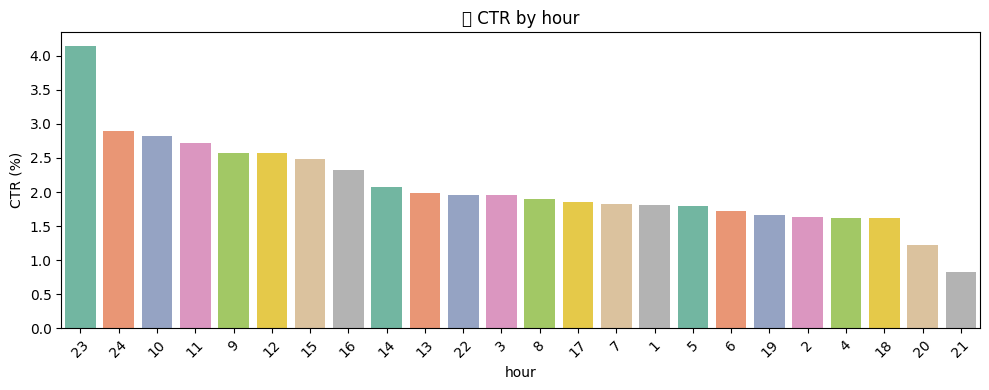

<ipython-input-7-9d0b7a347420>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ctr_data.index.astype(str), y=ctr_data.values, palette="Set2")
<ipython-input-7-9d0b7a347420>:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


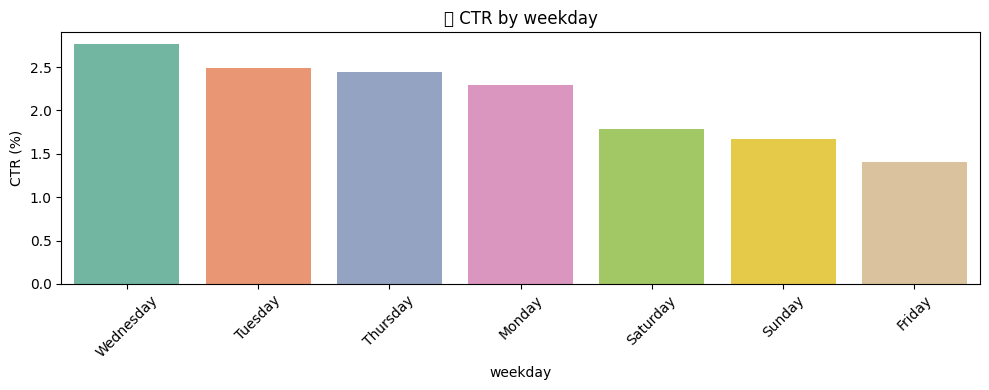

<ipython-input-7-9d0b7a347420>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ctr_data.index.astype(str), y=ctr_data.values, palette="Set2")
<ipython-input-7-9d0b7a347420>:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


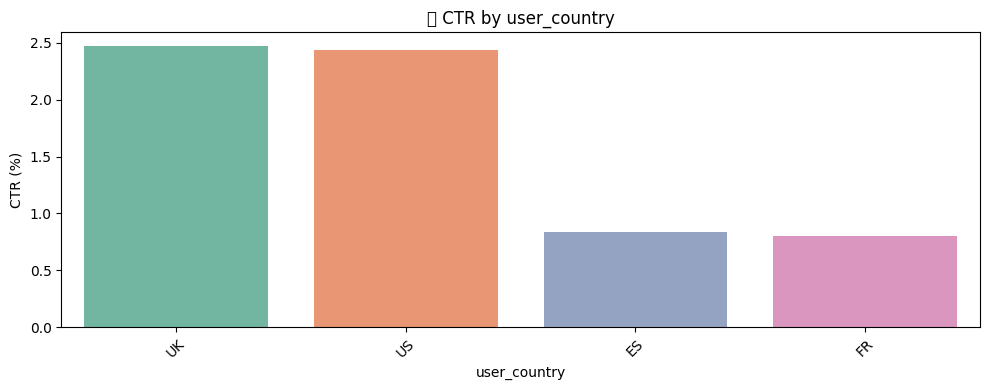

<ipython-input-7-9d0b7a347420>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ctr_data.index.astype(str), y=ctr_data.values, palette="Set2")
<ipython-input-7-9d0b7a347420>:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


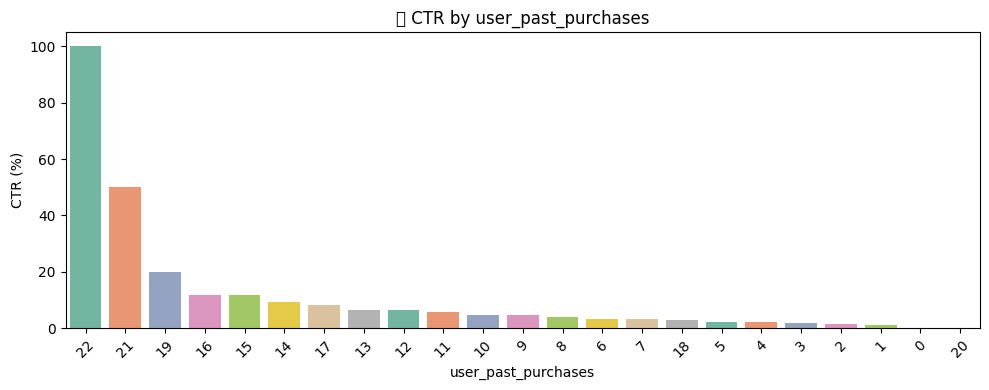

In [7]:
# Q4: Are there patterns across different segments (e.g., countries or email versions)?


# 🔍 Q4 Extended: CTR Across All Categorical Features

categorical_cols = X.select_dtypes(include="int64").columns.tolist() + \
                   X.select_dtypes(include="object").columns.tolist()

# Filter categorical columns from original dataframe
categorical_cols = [col for col in categorical_cols if col in email_df.columns and col not in ['clicked', 'opened', 'email_id']]

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    ctr_data = email_df.groupby(col)["clicked"].mean().sort_values(ascending=False) * 100
    sns.barplot(x=ctr_data.index.astype(str), y=ctr_data.values, palette="Set2")
    plt.title(f"📊 CTR by {col}")
    plt.ylabel("CTR (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
